# 振子のパラメータ同定(Gyro Boy) 002

In [3]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from decimal import *
from control import tf, tfdata, matlab
from control.matlab import *
from scipy import signal
from scipy.integrate import odeint

from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
import scipy.constants as cnst

from Modules import Modules
modules = Modules('')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

print("OK\n")

OK



In [5]:
# LPF
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を導出
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を導出
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタを適用
    return y  

In [4]:
# 近似
def calc_poly(df_value):
    # 近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    # 近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    # グラフ描画
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [5]:
# 2次系伝達関数モデル作成
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [6]:
# 最大値を取得
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [7]:
# am,bmを導出
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log1p((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [8]:
# グラフ描画
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.title('2nd order step', fontsize=10)
    plt.xlabel('time [sec]', fontsize=10)
    plt.ylabel('Output', fontsize=10)
    plt.xlim([0, x_max])
    plt.ylim([0, y_max])
    plt.tick_params(labelsize = 10)
    plt.tight_layout()
    plt.grid()
    plt.show()

In [91]:
# グラフ描画
def result_plot(x, u, t):
    fig=plt.figure()

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(t, x[:, 0], c = 'k')
    ax2.plot(t, x[:, 1], c = 'k')
    ax3.plot(t, x[:, 2], c = 'k')
    
    ax1.set_xlabel(r"$t$")
    ax2.set_xlabel(r"$t$")
    ax3.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$\theta_{1}$")
    ax2.set_ylabel(r"$\theta_{\mathrm{w}}$")
    ax3.set_ylabel(r"${\theta}^{(1)}_{1}$")
    
    fig.tight_layout()
    plt.show()
    
    fig2=plt.figure()
    ax_u = fig2.add_subplot(1,1,1)
    ax_u.plot(t, u, c = 'k')
    ax_u.set_xlabel(r"$t$")
    ax_u.set_ylabel(r"$u$")
    plt.show()
    return True

## データの読み込み

<Axes: >

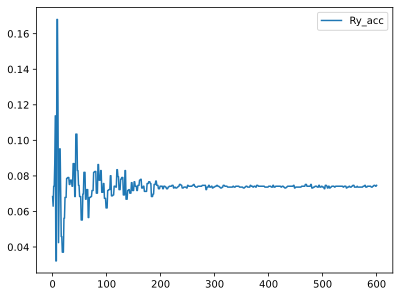

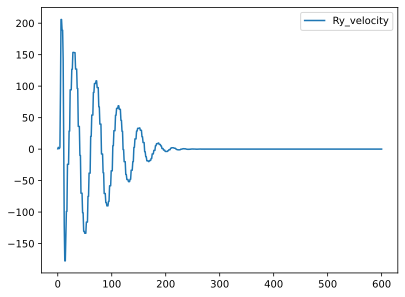

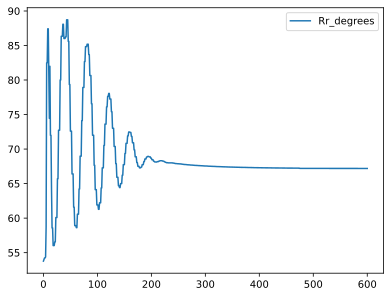

In [22]:
### サンプリング周波数200[Hz]で観測したデータ
#df = pd.read_csv('./param_ev3-005_1699278939.335626.tsv')
### Gyro Evolution 1
#df = pd.read_csv('/home/uecadmin/researchScript/param_ev3-007_1699595979.0359282.tsv')
### Gyro Boy Original 
df = pd.read_csv('./param_gyro-origin_001__1700890014.6128285.tsv')
df.plot(y='Ry_acc')
df.plot(y='Ry_velocity')
df.plot(y='Rr_degrees')

### 実験データの⊿tを配列化

In [24]:
time = 0
TimeSeries = []
for index, row in df.iterrows():
    if index == 0:
        TimeSeries.append(0)
    else:
        TimeSeries.append(TimeSeries[index - 1] + row['delta'])
    time = time + row['delta']
samplerate = 1.0 / (time / 600)
endtime = time

## 振り子の自由振動/減衰系のシュミレーション

In [27]:
### 実験結果からパラメータを取得
velocity = df['Ry_velocity'].values
degrees = df['Rr_degrees'].values
max_degress = max(degrees)
min_degress = min(degrees)
last_degrees = degrees[600]
offset = last_degrees
print(max_degress - last_degrees)
print(last_degrees - min_degress)
print(max_degress - min_degress)

21.528000000000006
13.41899999999999
34.946999999999996


In [29]:
### 振り子の自由振動
def wave_sym(t, v, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0) + offset
    # sol[0]が変位x1, sol[1]が速度x2となる
    #return [deg, v]
    return deg

In [31]:
### 可観測パラメータを定義
am = 16.994702595978385
bm = 99.93766838290357
#am = 8.272856311536618
#bm = 2.4549525908389445

g = 9.81     # 重力加速度
M = 0.80    # 振子の質量
m = 0.15    # タイヤの質量,EV3
#m = 0.12     # タイヤの質量,Spike L
lp = 0.115
# 重心位置から車軸の距離
rw = 0.026

21.528000000000006


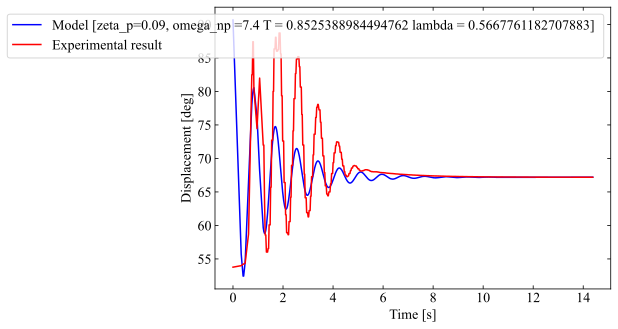

In [33]:
### 実験結果とサンプリング周波数,タイムスケールを同期させたシミュレート
t0 = TimeSeries[0]
t = TimeSeries
time = TimeSeries
zeta_p = 0.09
omgega_np = 7.4
theta_0 = max_degress - last_degrees
print(theta_0)
sol = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    sol.append(wave_sym(time[index], velocity[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# グラフ描画
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Displacement [deg]')

# データプロット
## 計算値
ax1.plot(time, sol, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')
## 実験結果
ax1.plot(TimeSeries, df['Rr_degrees'].values, label='Experimental result', c='r')

fig.tight_layout()
plt.legend(loc='upper right')

# グラフを表示する。
plt.show()
plt.close()

In [35]:
### 振り子の自由振動
def wave_sym2(t, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0)
    return deg

T : 0.8525388984494762
lambda : 0.5667761182707883
I : 0.005901373265157049


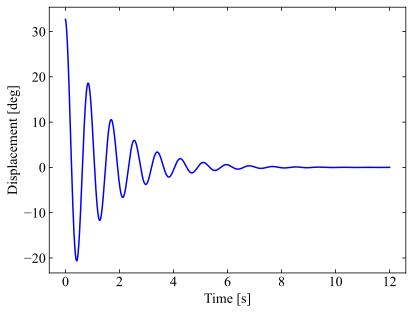

In [37]:
### データポイントを増やしてシミュレート
t0 = 0
et = 12
dt = 0.001
time = np.arange(t0, (et+dt), dt)
theta_0 = 30

# ---------------------------------------------------------------------- #
# mode 01
# ---------------------------------------------------------------------- #
zeta_p = 0.09
omgega_np = 7.4
mode1 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode1.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))
print('T : ' + str(T))
print('lambda : ' + str(lamb))

# ---------------------------------------------------------------------- #
# Iを導出
# ---------------------------------------------------------------------- #
I = (M*g*lp)/(np.power(omgega_np, 2)) - M * np.power(lp, 2)
print('I : ' + str(I))

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Displacement [deg]')
ax2.plot(time, mode1, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')

# ---------------------------------------------------------------------- #
# mode 02
# ---------------------------------------------------------------------- #
zeta_p = 0.2
omgega_np = 10
theta_0 = max_degress - last_degrees
mode2 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode2.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
## 計算値
#ax2.plot(time, mode2, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='g')


# グラフを表示する。
plt.show()
plt.close()

## モータの角加速度を制御する

### 最適レギュレータによるゲイン導出

In [103]:
### パラメータ導出

#### 周期T,減衰率λ
zeta_p = 0.9
omgega_np = 7.4

#### J
J = m * np.power(rw, 2) / 2
print('J : ' + str(J))

#### I
I = M * np.power(lp, 2) * (lp/0.2)
print('I : ' + str(I))

#### ωdp
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

#### Tpeak
T_peak = (2 * math.pi)/omega_dp
#### λ
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

#### γ,δp
gumma_p = (1/T_peak) * np.log(1/lamb)
delta_p = (2 * math.pi) / T_peak

#### ωnp,ζp
omega_np = np.sqrt(np.power(gumma_p, 2) + np.power(delta_p, 2))
print('ωnp : ' + str(omega_np))
zeta_p = gumma_p/omega_np

#### I + J + lp^2*M + 2*lp*M*rw + M*rw^2 + m*rw^2
param1 = I + J + pow(lp, 2)*M + 2*lp*M*rw + M*pow(rw, 2) + m*pow(rw, 2)

#### - J - lp * M * rw - M * rw^2 - m * rw^2
param2 = -J - lp*M*rw - M*pow(rw, 2) - m*pow(rw, 2)

a = (g * lp * M) / param1
b = param2 / param1

#### 行列定義
A = [[0, 1, 0]
     ,[a, 0, 0]
     ,[0, 0, 0]]
B = [[0]
    ,[b]
    ,[1]]
Q = [[10, 0, 0]
    ,[0, 10, 0]
    ,[0, 0, 100]]

##### 4x4の単位行列を生成
C = np.eye(3)

##### 3x1の零行列を生成
D = np.zeros([3, 1])

#### 最適レギュレータ
P = ss(A, B, C, D)
R = 100

F,X,E = lqr(P.A, P.B, Q, R)
F = -F

print('---- フィードバックゲイン ----')
print(F)
print(-(1/R) * P.B.T * X)

print('---- 閉ループ系 ----')
print(E)
print(np.linalg.eigvals(A + B * F))

J : 5.069999999999999e-05
I : 0.0060835
ωnp : 7.400000000000001
---- フィードバックゲイン ----
[[676.76688895 105.99986247   1.        ]]
[[  -0.          782.76675142 -105.99986247]
 [  -0.          122.60214234  -16.60227987]
 [  -0.            2.31325419   -1.31325419]]
---- 閉ループ系 ----
[-6.40669786 -6.36263673 -1.        ]
[-6.40669786 -6.36263673 -1.        ]


### ゲインを適用しない場合

True

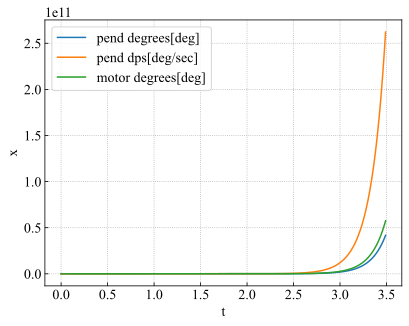

In [106]:
# 状態フィードバックゲインなし
Acl = P.A + P.B 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 3.5, 0.01)
X0 = [24, velocity[0], 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
ax.plot(t, x[:,2], label = 'motor degrees[deg]')
modules.plot_set(ax, 't', 'x', 'best')

### ゲインを適用する場合

True

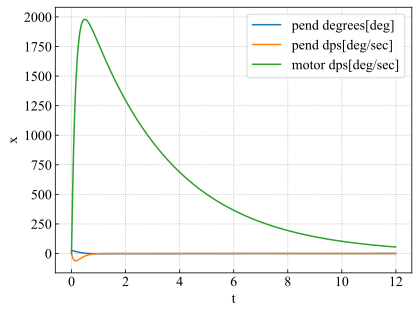

In [81]:
# 最適レギュレータにより導出した状態フィードバックゲインを適用する
#dps_a = df_motor['dps_a'].values
#a_position = df_motor['a_position'].values
#pos = a_position[1]/360

Acl = P.A + P.B*F 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 12, 0.01)
X0 = [24, velocity[0], 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
ax.plot(t, x[:,2], label = 'motor dps[deg/sec]')
modules.plot_set(ax, 't', 'x', 'best')

# 可制御性の確認 
Uc = ctrb(P.A, P.B)
print('Uc=\n', Uc)
print('det(Uc)=', np.linalg.det(Uc))
print('rank(Uc)=', np.linalg.matrix_rank(Uc))

In [66]:
# Controllability
Wc = ctrb(P.A, P.B)
a = np.mat(P.A)
print("Wc = ", Wc)
if np.linalg.matrix_rank(Wc) != a.shape[0]:
   print ("System not Controllability\n")
else :
   print ("System Controllability\n")

Wc =  [[ 0.         -0.13933353  0.        ]
 [-0.13933353  0.         -5.67972096]
 [ 1.          0.          0.        ]]
System Controllability



## 離散時間最適レギュレータ導出

### 連続時間

In [109]:
A = [[0, 1, 0]
     ,[a, 0, 0]
     ,[0, 0, 0]]
B = [[0]
    ,[b]
    ,[1]]
# 4x4の単位行列を生成
C = np.eye(3)
# 4x1の零行列を生成
D = np.zeros([3, 1])
P = ss(A, B, C, D)
Q = np.diag([10,10,100])
R = 100

Uc = ctrb(P.A, P.B)
rankUc = np.linalg.matrix_rank(Uc)
print(rankUc)

N = P.A.shape[0]

f, pp, e = lqr(P.A, P.B, Q, R)

print("f = ", f)

3
f =  [[-676.76688895 -105.99986247   -1.        ]]


[-6.40669786+0.j -6.36263673+0.j -1.        +0.j]


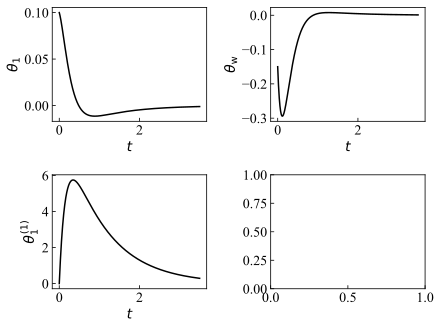

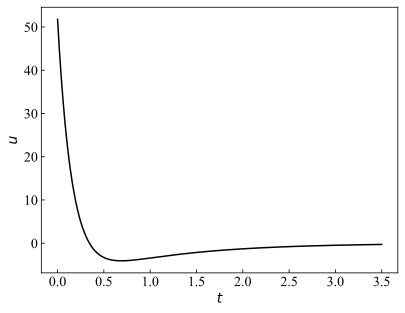

True

In [111]:
Acl = P.A - P.B @ f
fbcsys = ss(Acl, P.B, P.C, P.D)

print(pole(fbcsys))

x0 = np.array([0.1, -0.15, 0.0]).reshape(-1, 1)
Tc = np.arange(0, 3.5, 0.001)
x, t = initial(fbcsys, Tc, x0)

u = -f @ x.T
u = u.T

result_plot(x, u, t)

### 離散時間最適レギュレータ導出

In [114]:
T = 0.014  # local
#T = 0.022
dsys = c2d(P, T, method='zoh')
print(dsys)

<StateSpace>: sys[26]$sampled
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[1.00399748 0.01401865 0.        ]
     [0.57144911 1.00399748 0.        ]
     [0.         0.         1.        ]]

B = [[-1.36637793e-05]
     [-1.95326793e-03]
     [ 1.40000000e-02]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]]

dt = 0.014



In [116]:
#Q = np.diag([100, 10, 1, 10])
#R = 10000000

Ucd = ctrb(dsys.A, dsys.B)
rankUcd = np.linalg.matrix_rank(Ucd)
Nd = dsys.A.shape[0]
fd, Pd, ed = dlqr(dsys.A, dsys.B, Q, R)
print(rankUcd)

3


[0.91421101 0.9147753  0.98609766]


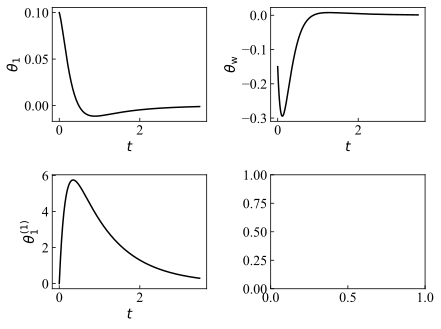

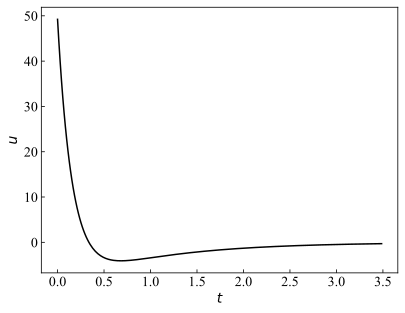

True

In [118]:
Adl = dsys.A - dsys.B @ fd
fbdsys = ss(Adl, dsys.B, dsys.C, dsys.D, dsys.dt)

print(abs(pole(fbdsys)))

x0 = np.array([0.1, -0.15, 0.0]).reshape(-1, 1)
Td = np.arange(0, 3.5, dsys.dt)
xd, td = initial(fbdsys, Td, x0)
ud = -fd @ xd.T
ud = ud.T

result_plot(xd, ud, td)

In [120]:
-fd

array([[643.38539181, 100.77138561,   0.90811407]])